In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


In [2]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [3]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1~3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 = (not X1) and X2
 - Y2 = not Y1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will converge to a strategy of polling X for as long as they yield information
on Y, and 

In [4]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step GRU
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [6]:
import lasagne

#only 10 hidden neurons
n_hid=10


observation_size = (None,)+tuple(env.observation_size)

_observation_layer = lasagne.layers.InputLayer(observation_size,name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(_observation_layer,
              {gru:_prev_state_layer},
              q_eval,resolver)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [8]:
#produce interaction sequences of length <= 10
state_seq,observation_seq,agent_state,action_seq,qvalues_seq = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)


hidden_seq = agent_state[gru]

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [9]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma,)


mse_Qloss = squarred_Qerror.sum(axis = 1).mean()

In [10]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [11]:
loss = mse_Qloss + reg_l2

#### Compute weight updates

In [12]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [13]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [14]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_Qloss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [15]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   hidden_seq=hidden_log,
                   action_names=env.feature_names,
                  
                  plot_policy = with_plots)

session # 0
 X1(qv = 0.0) -> -1.0 |  X1(qv = 0.0276150275022) -> -0.5 |  X1(qv = 0.0432757362723) -> -0.5 |  X1(qv = 0.0518216565251) -> -0.5 |  X1(qv = 0.0563119575381) -> -0.5 |  X1(qv = 0.0585893131793) -> -0.5 |  X3(qv = -0.0326397940516) -> -1.0 |  Y1(qv = 0.0408571660519) -> 3.0 |  Y2(qv = -0.032746642828) -> -3.0 |  Y1(qv = 0.101242035627) -> -0.5 | reached max session length


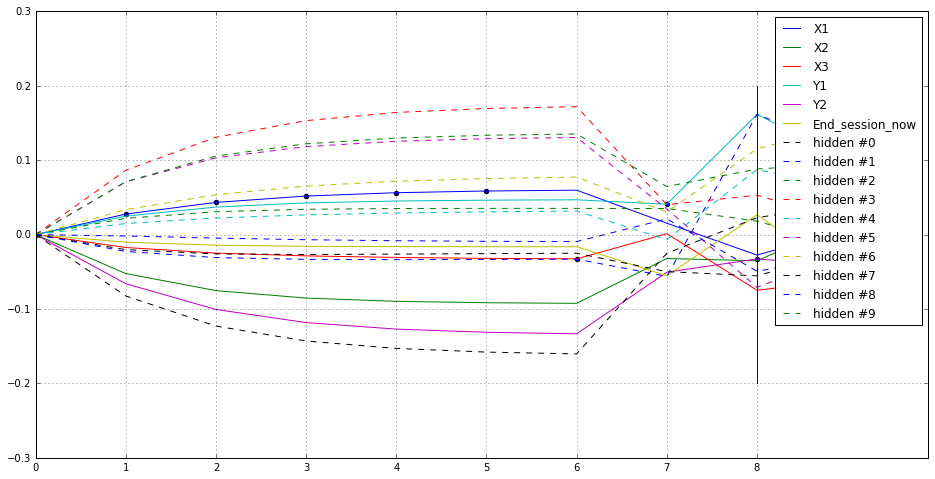

In [16]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [17]:
from agentnet.display import Metrics
score_log = Metrics()

In [18]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 8.56070, epsilon 0.96275, rewards: ( e-greedy -0.17500, greedy -0.10000) 
rec 8.548 reg 0.012
epoch 200,loss 11.55747, epsilon 0.92696, rewards: ( e-greedy -0.20250, greedy -0.21000) 
rec 11.545 reg 0.012
epoch 300,loss 8.90083, epsilon 0.89257, rewards: ( e-greedy -0.28725, greedy -0.54900) 
rec 8.888 reg 0.012
epoch 400,loss 12.90851, epsilon 0.85954, rewards: ( e-greedy -0.31352, greedy -0.69410) 
rec 12.896 reg 0.013
epoch 500,loss 8.40603, epsilon 0.82779, rewards: ( e-greedy -0.41717, greedy -0.98469) 
rec 8.393 reg 0.013
epoch 600,loss 7.94548, epsilon 0.79730, rewards: ( e-greedy -0.39546, greedy -0.97122) 
rec 7.932 reg 0.013
epoch 700,loss 10.80174, epsilon 0.76799, rewards: ( e-greedy -0.35091, greedy -0.75910) 
rec 10.788 reg 0.014
epoch 800,loss 12.10702, epsilon 0.73984, rewards: ( e-greedy -0.44582, greedy -0.68319) 
rec 12.092 reg 0.015
epoch 900,loss 8.24658, epsilon 0.71279, rewards: ( e-greedy -0.40124, greedy -0.51987) 
rec 8.231 reg 0.015
epoch 1000,

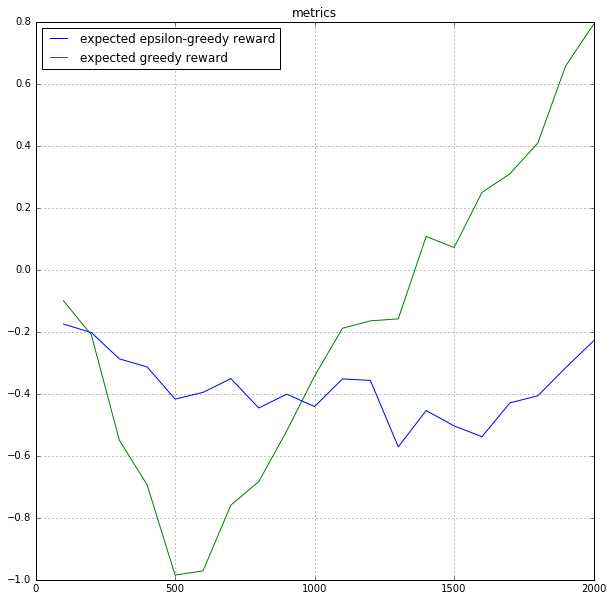

Random session examples
session # 0
 Y2(qv = 0.977761030197) -> 3.0 |  X2(qv = -0.148313447833) -> 1.0 |  X1(qv = -0.323231428862) -> 1.0 | 



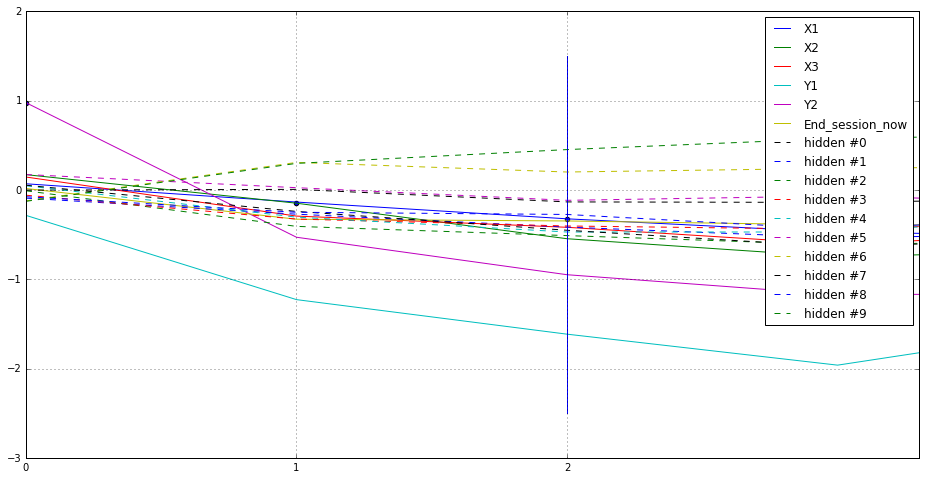

session # 1
 X1(qv = 0.069203555584) -> 1.0 |  X2(qv = -0.168100759387) -> -1.0 |  Y2(qv = 0.563958346844) -> 3.0 |  X1(qv = -0.297064512968) -> -0.5 | 



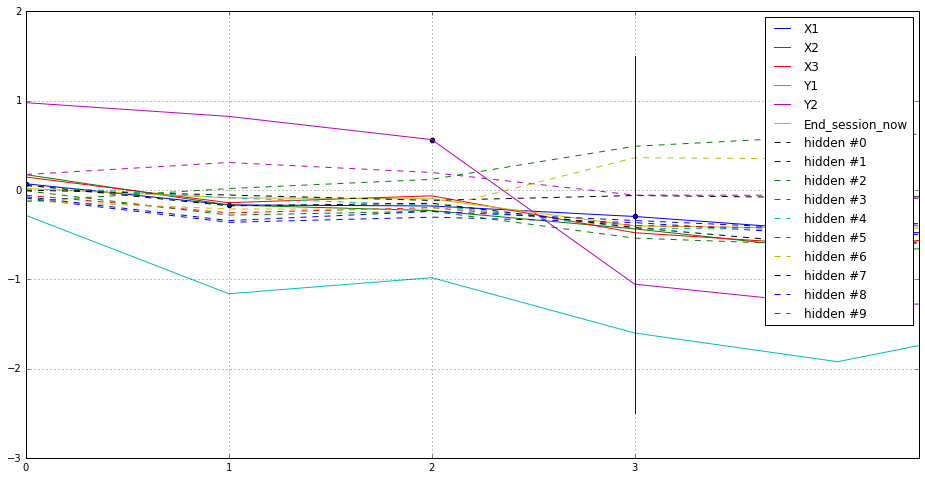

session # 2
 X3(qv = 0.14489684999) -> -1.0 |  X2(qv = 0.16483515501) -> 1.0 |  Y2(qv = 0.847879886627) -> 3.0 | 



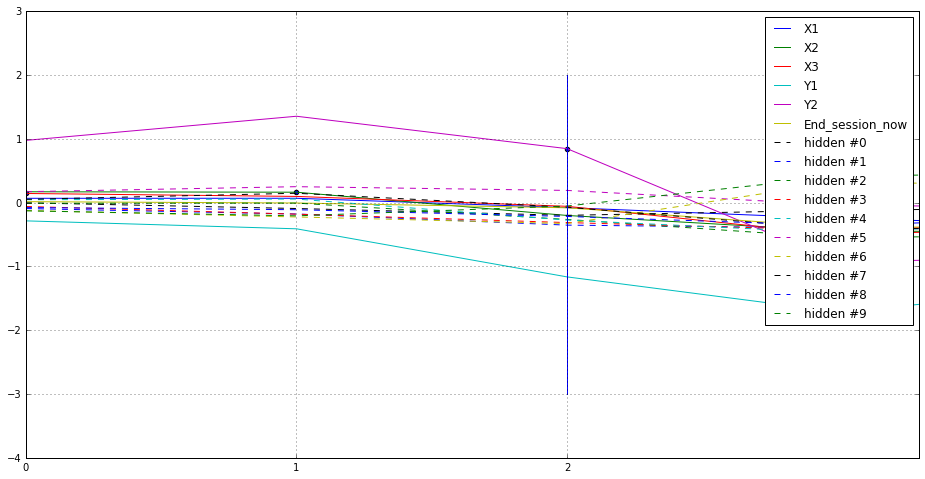

epoch 2100,loss 10.52327, epsilon 0.46012, rewards: ( e-greedy -0.17632, greedy 0.83784) 
rec 10.497 reg 0.026
epoch 2200,loss 6.63830, epsilon 0.44404, rewards: ( e-greedy 0.04131, greedy 0.99906) 
rec 6.611 reg 0.027
epoch 2300,loss 9.88851, epsilon 0.42859, rewards: ( e-greedy 0.05218, greedy 1.02915) 
rec 9.860 reg 0.028
epoch 2400,loss 6.80608, epsilon 0.41375, rewards: ( e-greedy 0.16696, greedy 1.12624) 
rec 6.777 reg 0.029
epoch 2500,loss 6.28137, epsilon 0.39949, rewards: ( e-greedy 0.26526, greedy 1.22361) 
rec 6.252 reg 0.030
epoch 2600,loss 9.53502, epsilon 0.38578, rewards: ( e-greedy 0.10874, greedy 1.02125) 
rec 9.505 reg 0.030
epoch 2700,loss 13.30972, epsilon 0.37262, rewards: ( e-greedy 0.16286, greedy 1.02913) 
rec 13.278 reg 0.031
epoch 2800,loss 7.26504, epsilon 0.35997, rewards: ( e-greedy 0.29158, greedy 1.17121) 
rec 7.233 reg 0.032
epoch 2900,loss 8.93560, epsilon 0.34781, rewards: ( e-greedy 0.16742, greedy 1.13909) 
rec 8.903 reg 0.033
epoch 3000,loss 12.1166

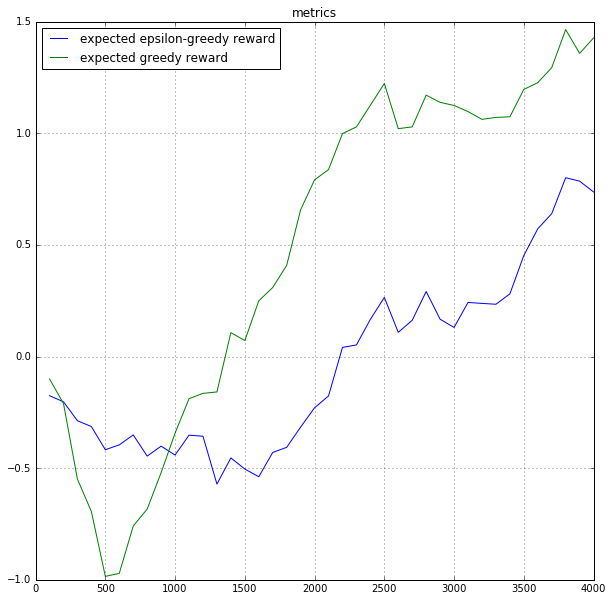

Random session examples
session # 0
 Y2(qv = 1.528840065) -> 3.0 |  X1(qv = 0.0380826294422) -> -1.0 |  X3(qv = -0.152861297131) -> -1.0 |  Y2(qv = -0.81703132391) -> -0.5 | 



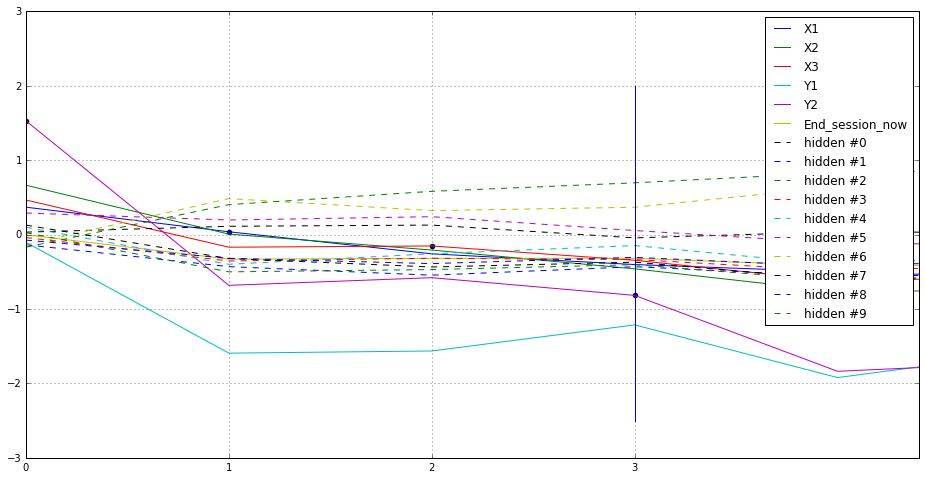

session # 1
 X1(qv = 0.368315786123) -> 1.0 |  Y2(qv = 1.45640540123) -> 3.0 |  X1(qv = -0.217494368553) -> -0.5 | 



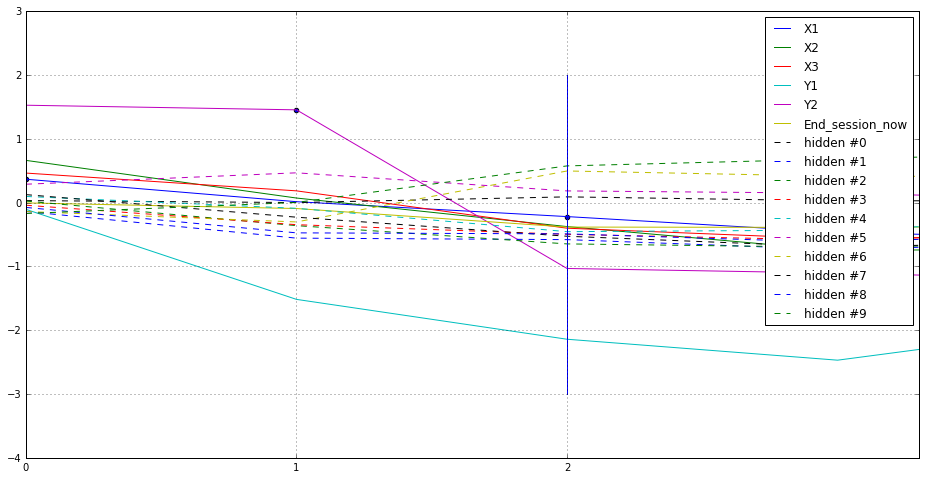

session # 2
 Y2(qv = 1.52883994579) -> 3.0 |  X1(qv = 0.0380826294422) -> 1.0 |  X1(qv = -0.342506498098) -> -0.5 | 



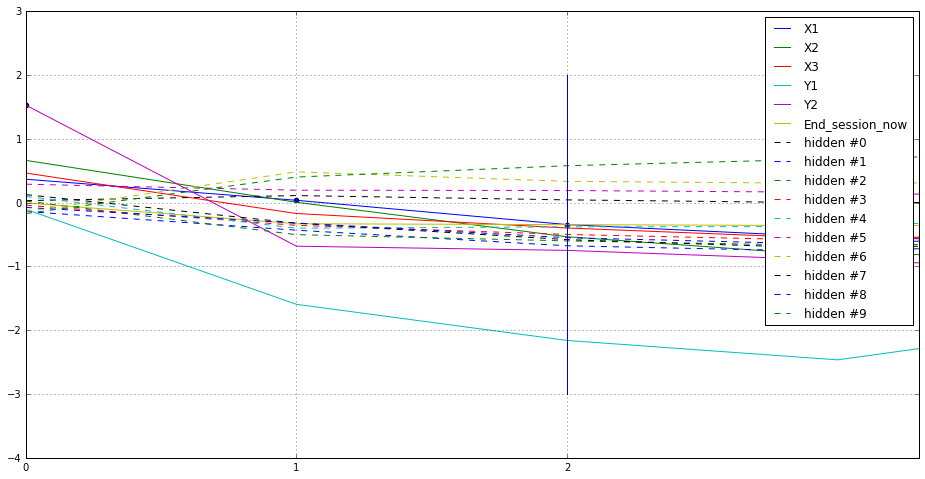

epoch 4100,loss 7.27561, epsilon 0.23428, rewards: ( e-greedy 0.78384, greedy 1.49497) 
rec 7.235 reg 0.041
epoch 4200,loss 5.36263, epsilon 0.22706, rewards: ( e-greedy 1.02545, greedy 1.66547) 
rec 5.321 reg 0.042
epoch 4300,loss 4.73329, epsilon 0.22011, rewards: ( e-greedy 1.01291, greedy 1.77392) 
rec 4.691 reg 0.042
epoch 4400,loss 5.09389, epsilon 0.21344, rewards: ( e-greedy 1.14162, greedy 1.87653) 
rec 5.051 reg 0.043
epoch 4500,loss 9.60825, epsilon 0.20703, rewards: ( e-greedy 1.23746, greedy 1.88888) 
rec 9.565 reg 0.043
epoch 4600,loss 7.40612, epsilon 0.20088, rewards: ( e-greedy 1.13371, greedy 1.82999) 
rec 7.362 reg 0.044
epoch 4700,loss 4.53435, epsilon 0.19496, rewards: ( e-greedy 1.32534, greedy 1.95199) 
rec 4.490 reg 0.044
epoch 4800,loss 10.18318, epsilon 0.18928, rewards: ( e-greedy 1.20781, greedy 1.83679) 
rec 10.138 reg 0.045
epoch 4900,loss 9.99400, epsilon 0.18382, rewards: ( e-greedy 1.13202, greedy 1.75811) 
rec 9.949 reg 0.045
epoch 5000,loss 7.04152, e

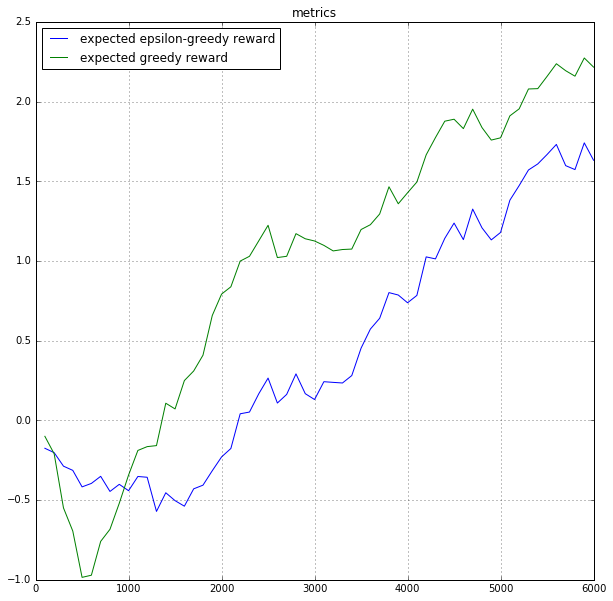

Random session examples
session # 0
 Y2(qv = 2.01261091232) -> 3.0 |  X1(qv = 0.30680206418) -> 1.0 |  X3(qv = -0.147039890289) -> -1.0 | 



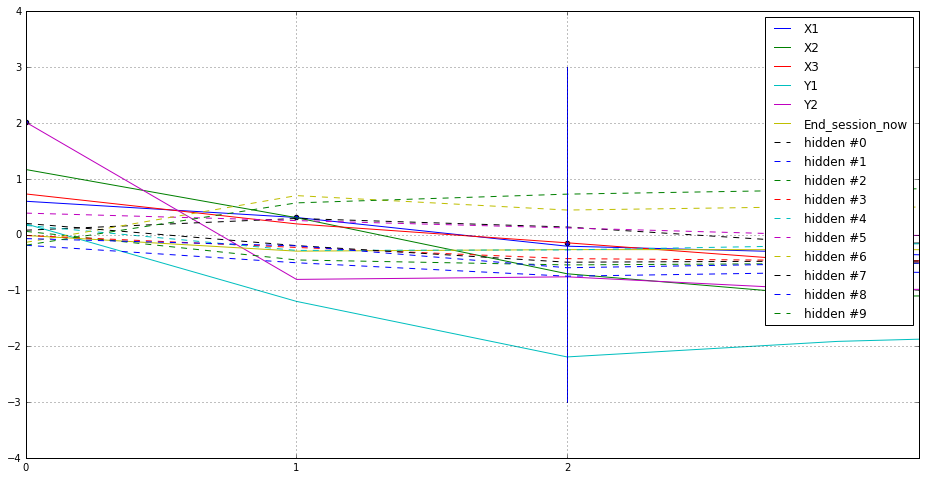

session # 1
 Y2(qv = 2.01261091232) -> 3.0 |  X1(qv = 0.30680206418) -> -1.0 |  X3(qv = 0.133270263672) -> 1.0 | 



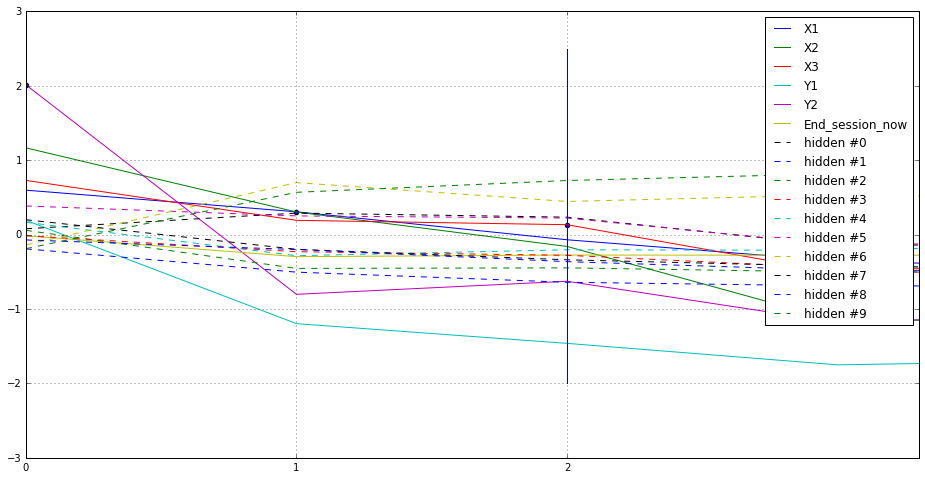

session # 2
 X2(qv = 1.16580867767) -> 1.0 |  Y2(qv = 1.15848016739) -> 3.0 |  X1(qv = 0.148518323898) -> 1.0 |  X1(qv = -0.242564052343) -> -0.5 | 



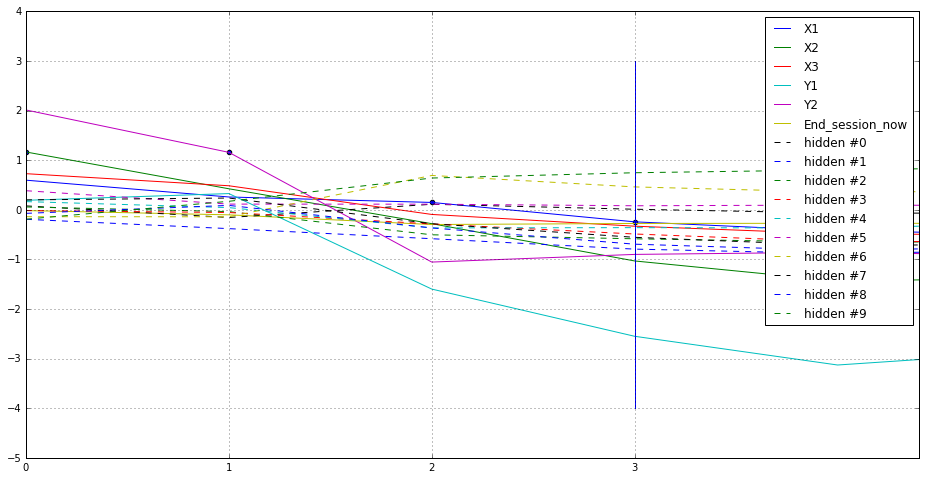

epoch 6100,loss 4.40243, epsilon 0.13280, rewards: ( e-greedy 1.66348, greedy 2.26915) 
rec 4.335 reg 0.067
epoch 6200,loss 7.72334, epsilon 0.12956, rewards: ( e-greedy 1.72713, greedy 2.29224) 
rec 7.654 reg 0.070
epoch 6300,loss 6.14500, epsilon 0.12644, rewards: ( e-greedy 1.79442, greedy 2.32302) 
rec 6.073 reg 0.072
epoch 6400,loss 4.84240, epsilon 0.12344, rewards: ( e-greedy 1.82998, greedy 2.37071) 
rec 4.769 reg 0.074
epoch 6500,loss 4.37418, epsilon 0.12056, rewards: ( e-greedy 1.90198, greedy 2.39364) 
rec 4.299 reg 0.075
epoch 6600,loss 3.25070, epsilon 0.11779, rewards: ( e-greedy 2.05678, greedy 2.50428) 
rec 3.173 reg 0.077
epoch 6700,loss 7.35932, epsilon 0.11513, rewards: ( e-greedy 2.02610, greedy 2.47385) 
rec 7.281 reg 0.079
epoch 6800,loss 6.85029, epsilon 0.11258, rewards: ( e-greedy 2.07349, greedy 2.50647) 
rec 6.770 reg 0.080
epoch 6900,loss 4.24896, epsilon 0.11013, rewards: ( e-greedy 2.06114, greedy 2.50082) 
rec 4.168 reg 0.081
epoch 7000,loss 5.62645, eps

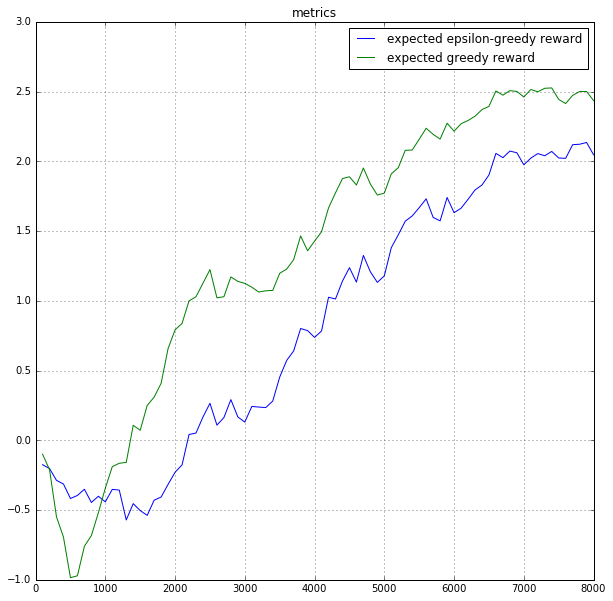

Random session examples
session # 0
 Y1(qv = 0.469259828329) -> -3.0 |  Y2(qv = 3.14225435257) -> 3.0 |  X2(qv = 0.607075870037) -> -1.0 |  X1(qv = 0.0864160358906) -> 1.0 | 



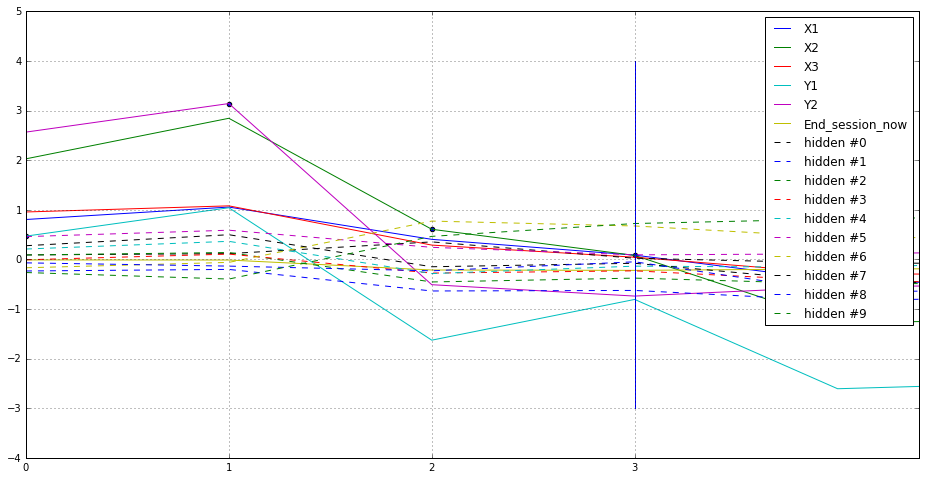

session # 1
 Y2(qv = 2.56648468971) -> 3.0 |  X1(qv = 0.319061994553) -> 1.0 |  X3(qv = -0.0734327435493) -> -1.0 |  X1(qv = -0.316920310259) -> -0.5 | 



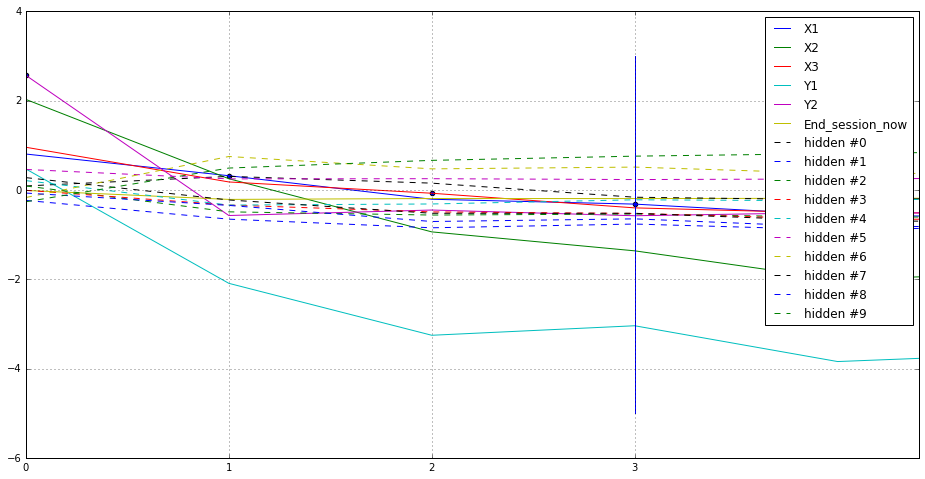

session # 2
 Y2(qv = 2.56648468971) -> 3.0 |  X1(qv = 0.319061994553) -> 1.0 |  X3(qv = -0.0734327435493) -> 1.0 | 



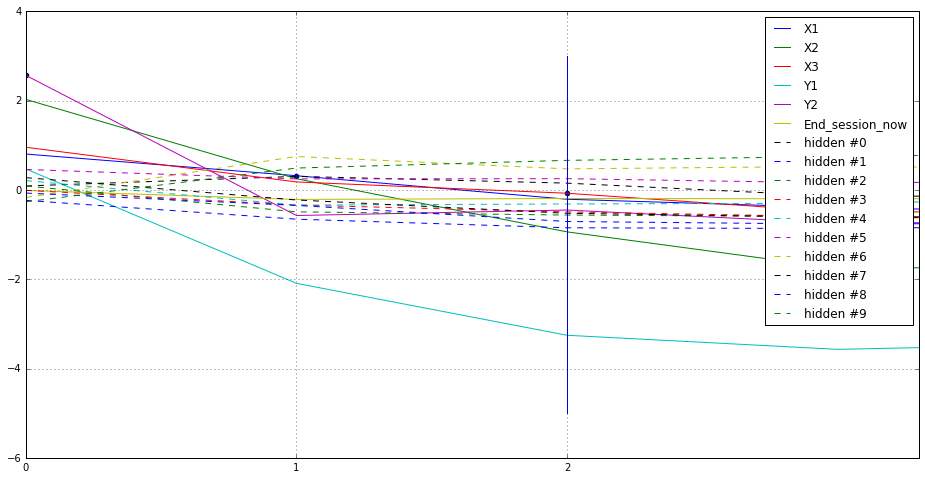

epoch 8100,loss 2.95192, epsilon 0.08721, rewards: ( e-greedy 2.01689, greedy 2.42180) 
rec 2.864 reg 0.088
epoch 8200,loss 3.10935, epsilon 0.08575, rewards: ( e-greedy 2.05520, greedy 2.41962) 
rec 3.022 reg 0.088
epoch 8300,loss 2.43011, epsilon 0.08435, rewards: ( e-greedy 2.11468, greedy 2.49766) 
rec 2.342 reg 0.088
epoch 8400,loss 2.67458, epsilon 0.08300, rewards: ( e-greedy 2.18821, greedy 2.54789) 
rec 2.587 reg 0.088
epoch 8500,loss 3.43668, epsilon 0.08170, rewards: ( e-greedy 2.19939, greedy 2.55310) 
rec 3.349 reg 0.088
epoch 8600,loss 2.90245, epsilon 0.08046, rewards: ( e-greedy 2.25945, greedy 2.57779) 
rec 2.815 reg 0.088
epoch 8700,loss 2.71060, epsilon 0.07927, rewards: ( e-greedy 2.35351, greedy 2.64001) 
rec 2.623 reg 0.088
epoch 8800,loss 2.43738, epsilon 0.07812, rewards: ( e-greedy 2.33816, greedy 2.62601) 
rec 2.350 reg 0.088
epoch 8900,loss 2.62381, epsilon 0.07702, rewards: ( e-greedy 2.31934, greedy 2.61341) 
rec 2.536 reg 0.088
epoch 9000,loss 2.83980, eps

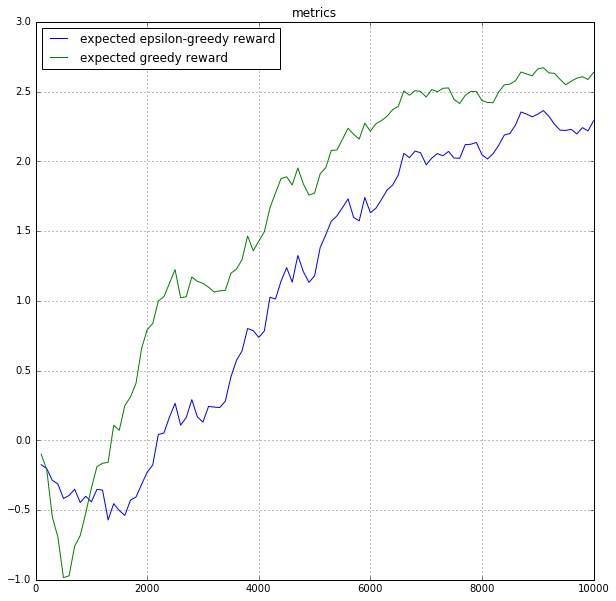

Random session examples
session # 0
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878136873) -> -1.0 |  X3(qv = 0.0672844946384) -> 1.0 | 



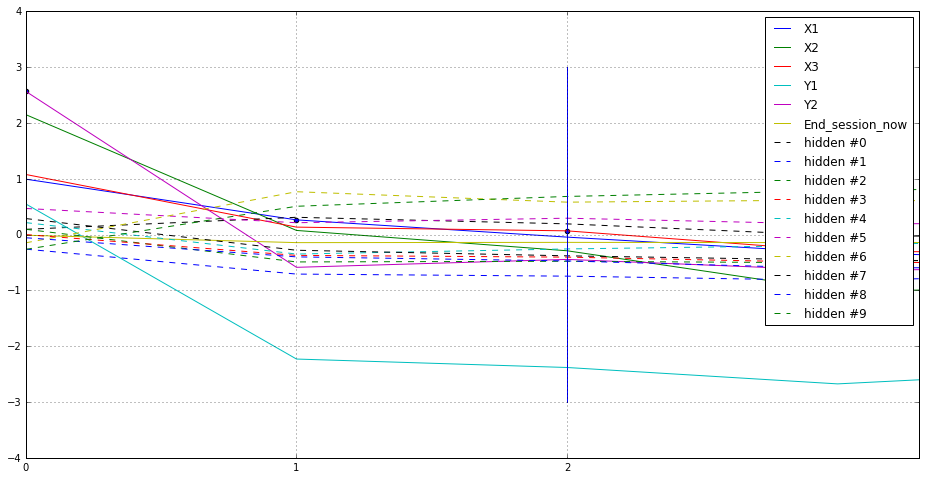

session # 1
 Y2(qv = 2.56533789635) -> -3.0 |  X2(qv = 3.72761273384) -> 1.0 |  Y1(qv = 2.93797540665) -> 3.0 |  X3(qv = -0.0299176573753) -> -1.0 | 



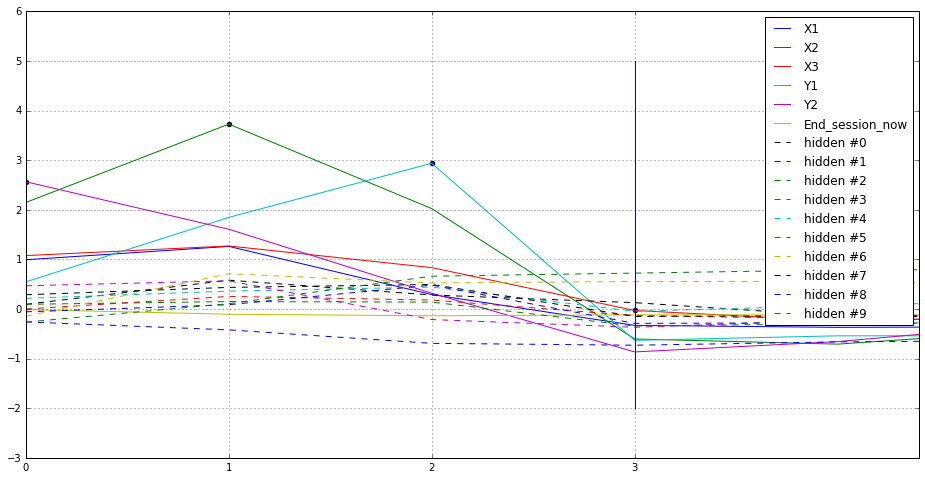

session # 2
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878166676) -> 1.0 |  X3(qv = -0.045528948307) -> 1.0 | 



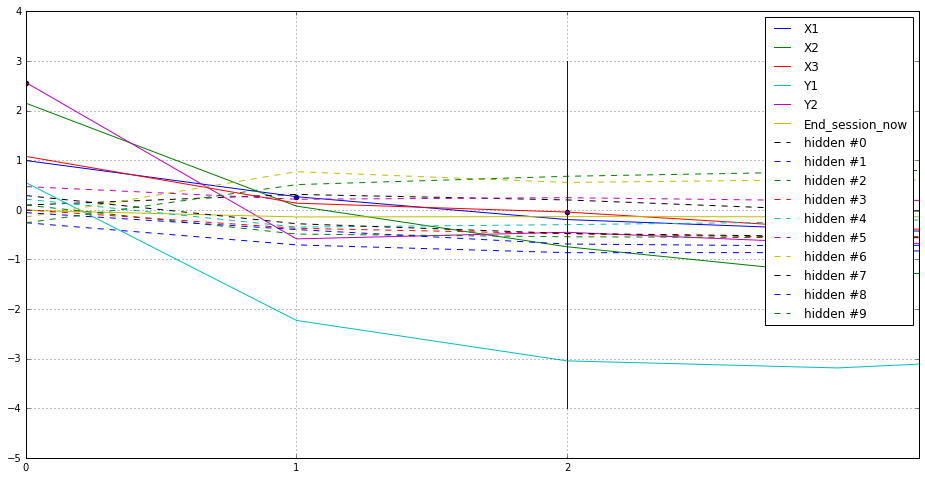

In [19]:
n_epochs = 10000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %2000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results

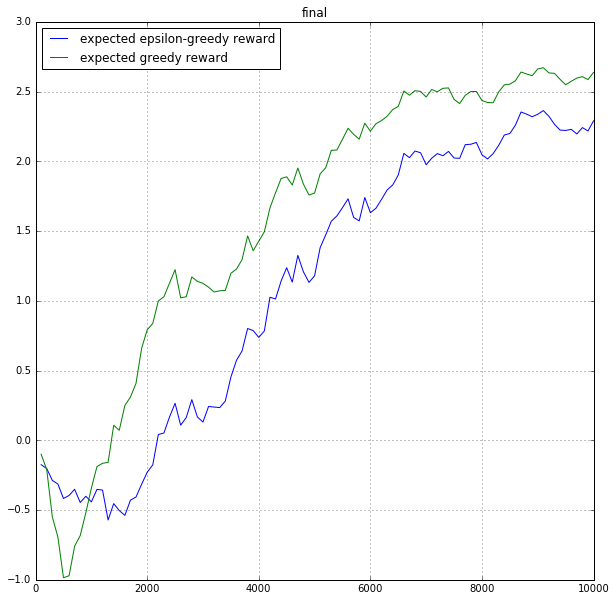

In [20]:
score_log.plot("final")

Random session examples
session # 0
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878166676) -> 1.0 |  X3(qv = -0.0455290079117) -> -1.0 | 



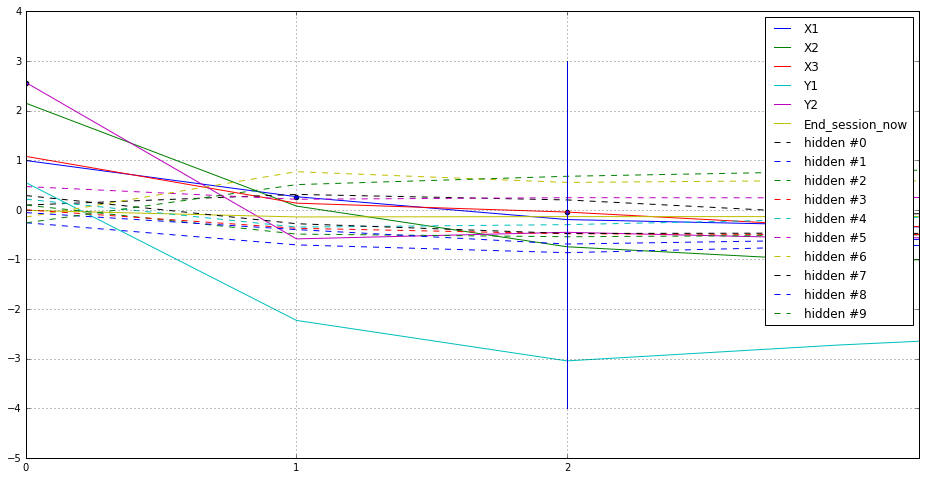

session # 1
 Y2(qv = 2.56533789635) -> -3.0 |  X2(qv = 3.72761273384) -> 1.0 |  Y1(qv = 2.93797516823) -> 3.0 |  X3(qv = -0.02991771698) -> -1.0 | 



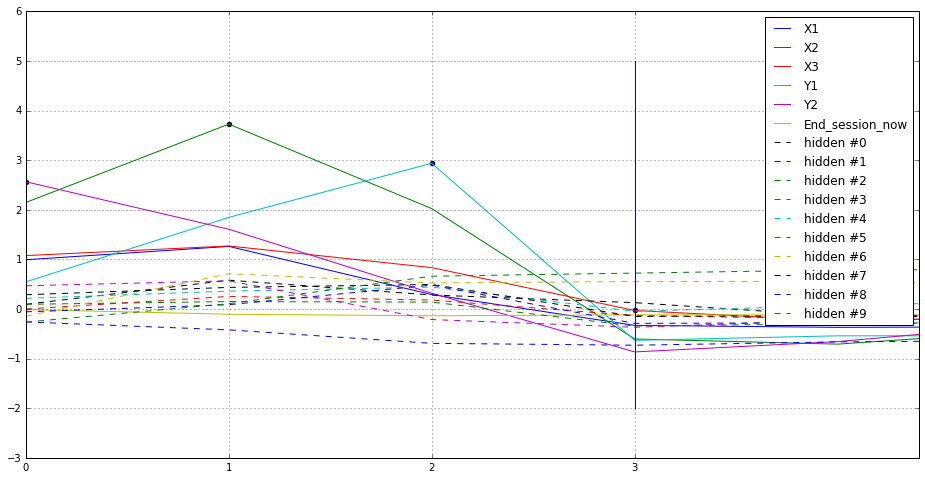

session # 2
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878166676) -> -1.0 |  X3(qv = 0.0672844946384) -> -1.0 | 



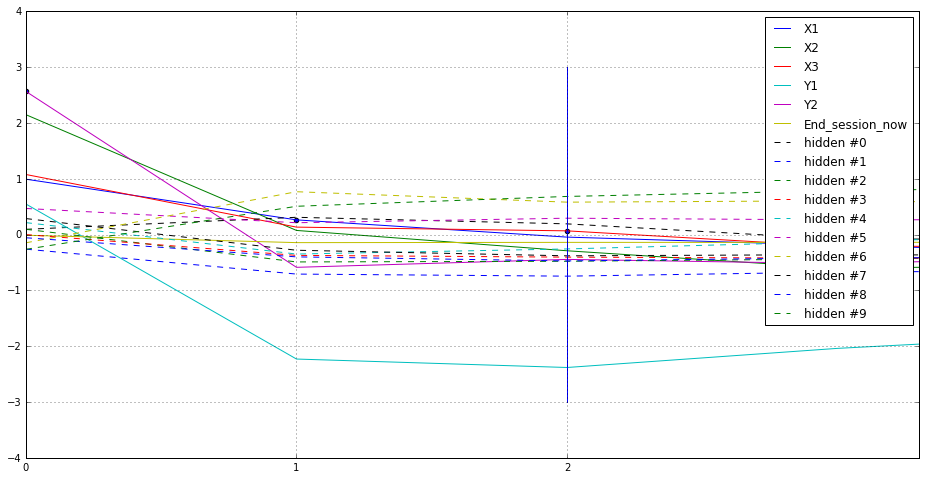

session # 3
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878166676) -> -1.0 |  X3(qv = 0.0672844946384) -> -1.0 | 



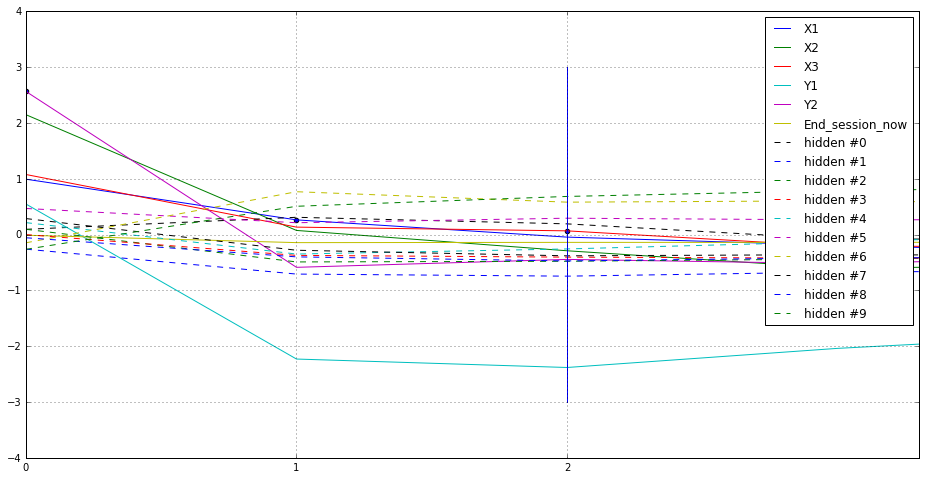

session # 4
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878166676) -> 1.0 |  X3(qv = -0.0455290079117) -> 1.0 | 



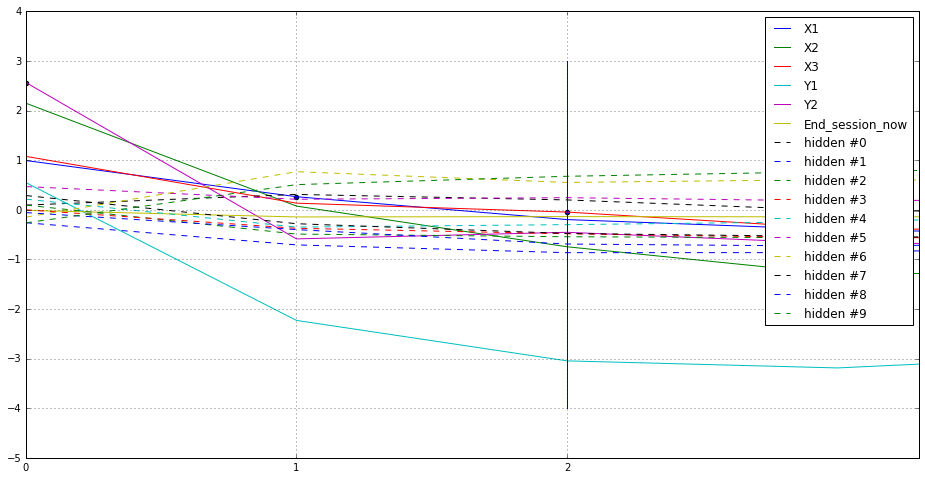

session # 5
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878166676) -> -1.0 |  X3(qv = 0.0672844946384) -> 1.0 | 



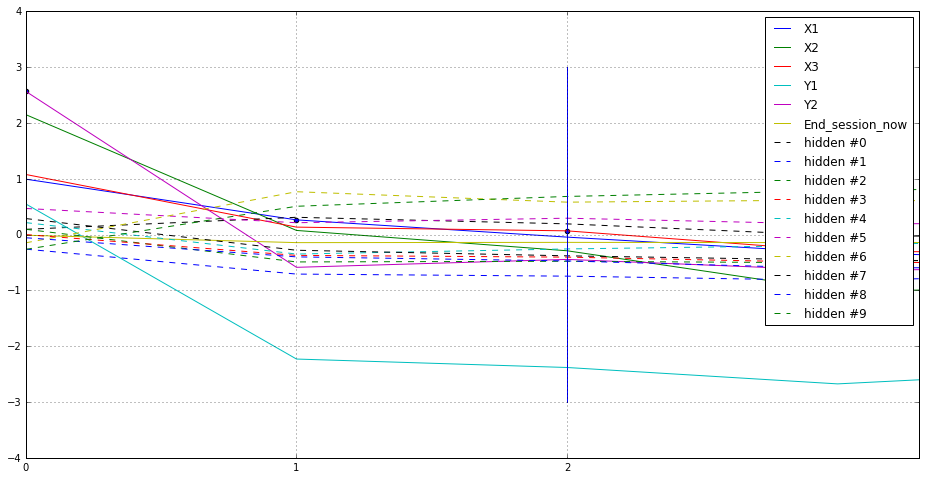

session # 6
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878166676) -> 1.0 |  X3(qv = -0.0455290079117) -> 1.0 | 



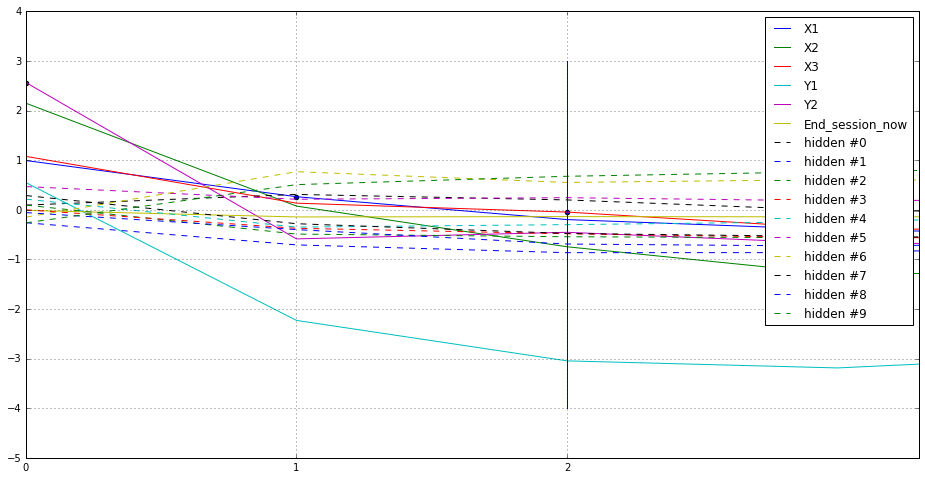

session # 7
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878166676) -> 1.0 |  X3(qv = -0.0455290079117) -> -1.0 | 



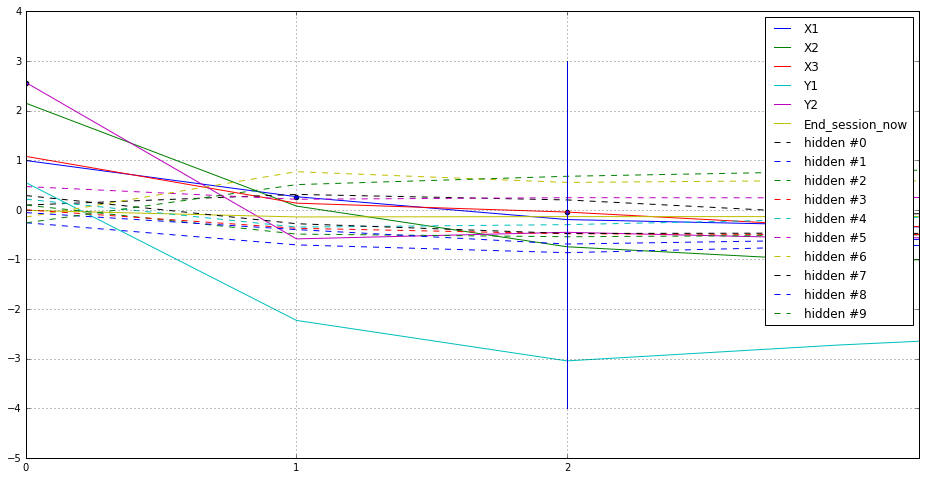

session # 8
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878136873) -> 1.0 |  X3(qv = -0.0455290079117) -> 1.0 | 



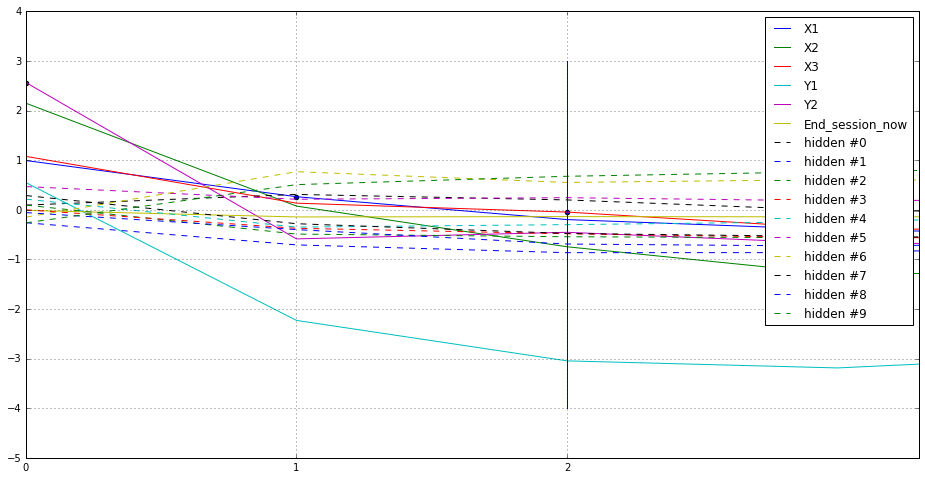

session # 9
 Y2(qv = 2.56533789635) -> 3.0 |  X1(qv = 0.263878136873) -> 1.0 |  X3(qv = -0.0455290079117) -> 1.0 | 



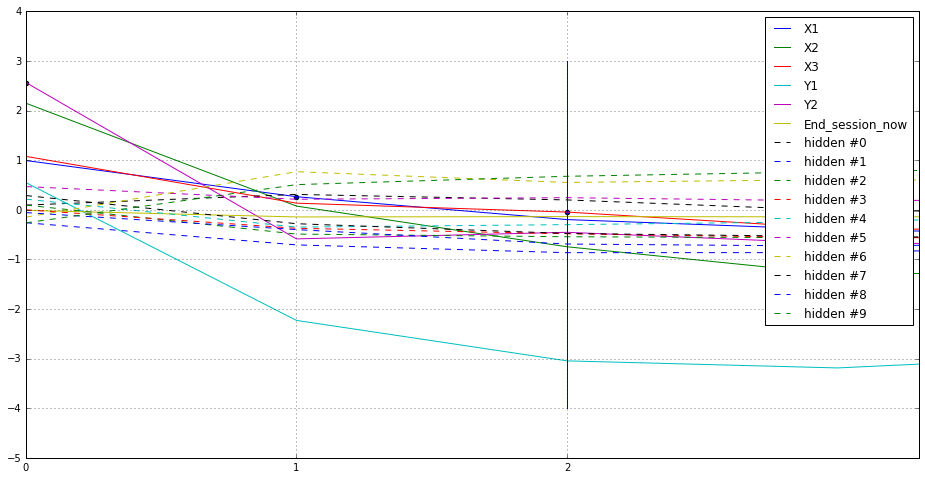

In [21]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
